In [1]:
import numpy as np
import drjit as dr
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import LambertianPattern, DirectivePattern, BackscatteringPattern,\
                      load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, cpx_abs, cpx_convert

no_preview = False # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization


from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, watt_to_dbm,\
                      RadioMapSolver, PathSolver

In [2]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("Denver/denver.xml")

# scene = load_scene("boulder_plane_itu2/boulder_plane_itu.xml")
# scene = load_scene("Denver_Scene/Boulder2_2/Boulder2.xml")
scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
# scene = load_scene("blouder_plane/boulder_plane_itu.xml")

In [3]:

nbs = 1            # Number of gNB/base stations
nsect = 3    # Usually 3, for sector-based coverage

# sec1
p1 = [-438.86474609, 954.68139648, 1.88]
p2 = [-832.86474609, 53.68139648, 1.88]

# sec2
p3 = [-310.86474609, -926.31860352, 1.88]
p4 = [-71.86474609, -636.31860352, 1.88]
p5 = [-677.86474609, -1027.31860352, 1.88]
p6 = [-729.86474609, -1069.31860352, 1.88]
p7 = [-268.86474609, -1116.31860352, 1.88]

# sec3
p8 = [1317.13525391, -1151.31860352, 1.88]
p9 = [786.13525391, 345.68139648, 1.88]
p10 = [1392.13525391, -369.31860352, 1.88]
p11 = [1253.13525391, -213.31860352, 1.88]
p12 = [1434.13525391, 762.68139648, 1.88]
p13 = [1116.13525391, -910.31860352, 1.88]
p14 = [1181.13525391, 91.68139648, 1.88]
tx_pos = [[0,0,45]]
bs_tn_pos = np.array([p1,  p3, p11])

In [4]:
data = np.load("beamforming_results6.npz")
print(data.files)
v_t = data["w_t_record"].squeeze(-1)
rx_ntn_pos = data["rx_ntn_pos"]
bs_tn_pos = data["bs_tn_pos"]
v_null = data["v_null_lambda_100000000000.0"].squeeze(-1) # 
ntn_pos = np.load('left_ntn_pos6.npy')

['w_t_record', 'rx_ntn_pos', 'bs_tn_pos', 'v_null_lambda_10000000000.0', 'v_null_lambda_100000000000.0', 'v_null_lambda_1000000000000.0']


In [5]:
v_t.shape

(3, 64)

In [6]:
tx_rows = 4
tx_cols = 16
display_bs_radius= 55
display_vic_radius = 30
display_tn_radius = 45
scene.bandwidth = 100e6
scene.frequency = 9.99e9
for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name)   
    
scene.tx_array = PlanarArray(
    num_rows = tx_rows,
    num_cols = tx_cols,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    polarization="V",
    pattern="tr38901"
)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")
for i in range(nbs):
    for s in range(nsect):
        yaw = 2.0 * np.pi * s / nsect
        tx = sionna.rt.Transmitter(
            name=f"tx-{s}",
            position=tx_pos[i],
            power_dbm=30,
            color=(0.0, 0.0, 0.0),
            display_radius=display_bs_radius,
            # orientation=[yaw, 0, -0.1745329252]
            orientation=[yaw, 0, -0.0873]
            )
        scene.add(tx)
        
# num_rx = bs_tn_pos.shape[0]
num_rx = ntn_pos.shape[0]
for i in range(num_rx):
    rx_position = ntn_pos[i]
    rx = sionna.rt.Receiver(
        name=f"rx-{i}",
        position=rx_position,  
        color=(1.0, 0.0, 0.0),
        display_radius=display_vic_radius,
    )
    scene.add(rx)
    rx.look_at(tx)
    
rx = sionna.rt.Receiver(
name=f"rx-{i+1}",
position=p1,  
color=(0, 0, 1),
display_radius=display_tn_radius,
)
scene.add(rx)
rx.look_at(tx)

rx = sionna.rt.Receiver(
name=f"rx-{i+2}",
position=p3,  
color=(0.0, 1.0, 0.0),
display_radius=display_tn_radius,
)
scene.add(rx)
rx.look_at(tx)

rx = sionna.rt.Receiver(
name=f"rx-{i+3}",
position=p11,  
color=(0, 1, 1),
display_radius=display_tn_radius,
)      
scene.add(rx)
rx.look_at(tx)
        


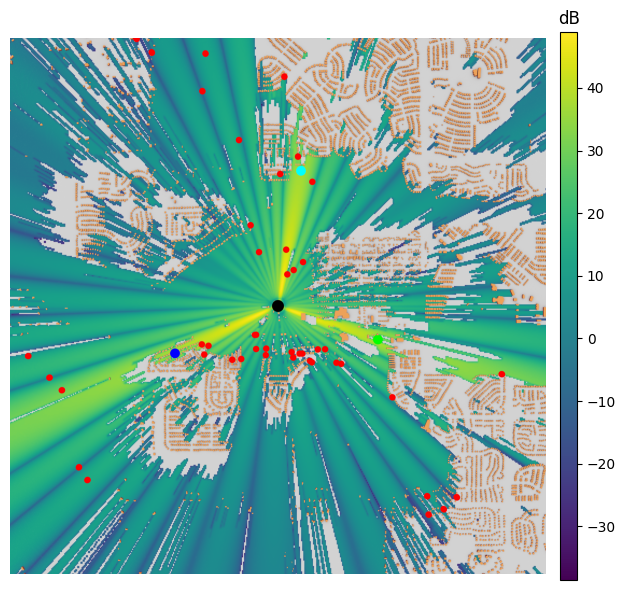

In [9]:
w_t= v_t
w_t[:3] = w_t[[0,1,2]]
precoding_vec_real = mi.TensorXf(w_t.real)
precoding_vec_imag = mi.TensorXf(w_t.imag)

precoding_vec = (precoding_vec_real, 
                 precoding_vec_imag)

# precoding_vec = (precoding_vec_imag, 
#                  precoding_vec_real)
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=0,           # Maximum number of ray scene interactions
               samples_per_tx=10**9 , # If you increase: less noise, but more memory required
               precoding_vec=precoding_vec,
               cell_size=(10, 10),      # Resolution of the radio map
               center=[0, 0, 0.1],      # Center of the radio map
               size=[6000, 6000],       # Total size of the radio map
               orientation=[0, 0, 0])
# rm.show(metric="path_gain" );
from sionna.rt import Camera
my_cam = Camera(position=[0,0, 6000], look_at=[0, 0, 0])

scene.render(camera=my_cam,
              radio_map= rm,
                #    paths=paths,
                   resolution=(8000, 8000),
                   rm_show_color_bar=True,
                  #  rm_vmin = -25,
                  #  rm_vmax = 45,
                   rm_metric='inr',
                   num_samples=64);

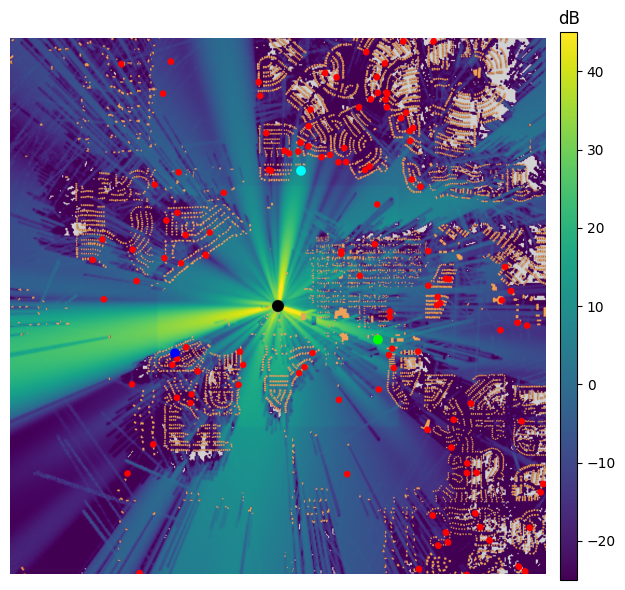

In [12]:
w_t= v_null
w_t[:3] = w_t[[0,1,2]]
precoding_vec_real = mi.TensorXf(w_t.real)
precoding_vec_imag = mi.TensorXf(w_t.imag)

precoding_vec = (precoding_vec_real, 
                 precoding_vec_imag)

# precoding_vec = (precoding_vec_imag, 
#                  precoding_vec_real)
rm_solver2 = RadioMapSolver()
rm2 = rm_solver2(scene,
               max_depth=3,           # Maximum number of ray scene interactions
               samples_per_tx=10**9 , # If you increase: less noise, but more memory required
               precoding_vec=precoding_vec,
               cell_size=(10, 10),      # Resolution of the radio mapS
               center=[0, 0, 0.1],      # Center of the radio map
               size=[6000, 6000],       # Total size of the radio map
               orientation=[0, 0, 0])
# rm.show(metric="path_gain" );

my_cam = Camera(position=[0,0, 6000], look_at=[0, 0, 0])
scene.render(camera=my_cam,
              radio_map= rm2,
               #     paths=paths,
                   resolution=(8000, 8000),
                   rm_show_color_bar=True,
                   rm_vmin = -25,
                   rm_vmax = 45,
                   rm_metric='inr',
                   num_samples=64);

In [8]:
tx_rows = 32
tx_cols = 32
display_bs_radius= 45*3
display_vic_radius = 20*3
display_tn_radius = 35*3
scene.bandwidth = 100e6
scene.frequency = 9.99e9
for tx_name in scene.transmitters:
    scene.remove(tx_name)
for rx_name in scene.receivers:
    scene.remove(rx_name)   
    
scene.tx_array = PlanarArray(
    num_rows = tx_rows,
    num_cols = tx_cols,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    polarization="V",
    pattern="tr38901"
)
scene.rx_array = PlanarArray(num_rows=32,
                             num_cols=32,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")
for i in range(nbs):
    for s in range(nsect):
        yaw = 2.0 * np.pi * s / nsect
        tx = sionna.rt.Transmitter(
            name=f"tx-{s}",
            position=tx_pos[i],
            power_dbm=30,
            color=(0.0, 0.0, 0.0),
            display_radius=display_bs_radius,
            # orientation=[yaw, 0, -0.1745329252]
            orientation=[yaw, 0, -0.0873]
            )
        scene.add(tx)
        
# num_rx = bs_tn_pos.shape[0]
num_rx = ntn_pos.shape[0]
for i in range(num_rx):
    rx_position = ntn_pos[i]
    rx = sionna.rt.Receiver(
        name=f"rx-{i}",
        position=rx_position,  
        color=(1.0, 0.0, 0.0),
        display_radius=display_vic_radius,
    )
    scene.add(rx)
    rx.look_at(tx)
    
rx = sionna.rt.Receiver(
name=f"rx-{i+1}",
position=p1,  
color=(0, 0, 1),
display_radius=display_tn_radius,
)
scene.add(rx)
rx.look_at(tx)

rx = sionna.rt.Receiver(
name=f"rx-{i+2}",
position=p3,  
color=(0.0, 1.0, 0.0),
display_radius=display_tn_radius,
)
scene.add(rx)
rx.look_at(tx)

rx = sionna.rt.Receiver(
name=f"rx-{i+3}",
position=p11,  
color=(0, 1, 1),
display_radius=display_tn_radius,
)      
scene.add(rx)
rx.look_at(tx)
        
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=3,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

RuntimeError: drjit.cuda.ad.TensorXf.__add__(): jit_var_counter(): tried to create an array with 9361686528 entries, which exceeds the limit of 2^32 == 4294967296 entries.

In [ ]:
scene.preview( paths = paths,clip_at=None, show_devices=True);

In [ ]:
# my_cam = Camera(position=[0,-6000, 4000], look_at=[0, 0, 0])
# scene.render(camera=my_cam,
#             #   radio_map= rm2,
#                    paths=paths,
#                    resolution=(5000, 5000),
#                 #    rm_show_color_bar=True,
#                 #    rm_vmin = -25,
#                 #    rm_vmax = 45,
#                 #    rm_metric='inr',
#                    num_samples=128);

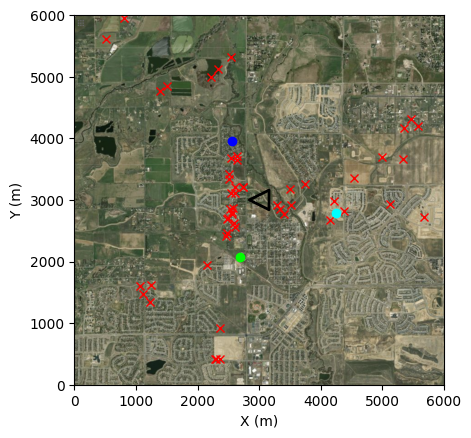

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread("../Denver_Scene/Boulder/boulder6_6.png")
plt.figure()
plt.imshow(img, extent=[0, 6000, 0, 6000])
plt.xlim(0, 6000)
plt.ylim(0, 6000)
# plt.title("Plot Points on 6000m x 6000m Image")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.scatter(3000, 3000, marker='<', s=200, facecolors='none', edgecolors='black', linewidths=2)
for pos in ntn_pos:
    x, y = pos[0]+3000, pos[1]+3000
    plt.plot(x, y, marker='x', color='red')
# plt.grid(True)

color_dot = [(0,0,1),(0,1,0),(0, 1, 1)]
for i, pos in enumerate(bs_tn_pos):
    x, y = pos[0] + 3000, pos[1] + 3000
    plt.plot(x, y, marker='o', color=color_dot[i % len(color_dot)], linestyle='') 

plt.show()

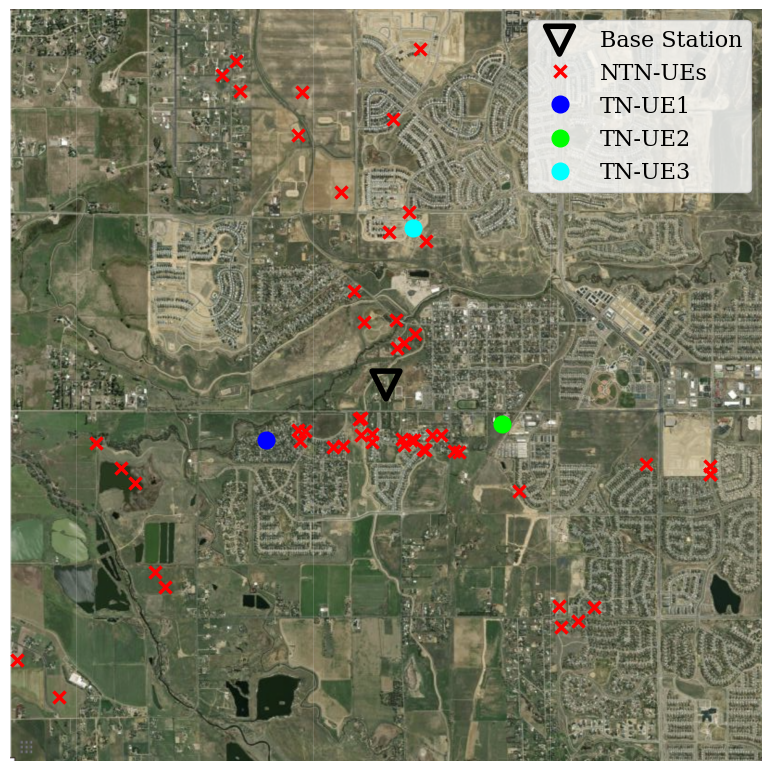

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# 读取并旋转图像
img = mpimg.imread("../Denver_Scene/Boulder/boulder6_6.png")
img_rotated = np.rot90(img)  

# 配置字体为 Times New Roman，并设置字号
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
    'font.size': 16,         # 基础字体大小
    'axes.titlesize': 16,    # 图标题大小
    'axes.labelsize': 16,    # 坐标轴标签大小
    'xtick.labelsize': 16,   # x 轴刻度文字大小
    'ytick.labelsize': 16    # y 轴刻度文字大小
})

# 创建图像和坐标轴，同时调整图像尺寸以便留出图例空间
# fig, ax = plt.subplots(figsize=(8, 8))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_rotated, extent=[0, 6000, 0, 6000])
ax.axis('off')  # 隐藏坐标轴

# 绘制中心参考点，并设置图例标签
x_old, y_old = 3000, 3000
x_new, y_new = -y_old + 6000, x_old
ax.scatter(x_new, y_new, marker='v', s=400, facecolors='none',
           edgecolors='black', linewidths=4, label="Base Station")

# 绘制 ntn_pos 点，添加图例标签到第一个点
for idx, pos in enumerate(ntn_pos):
    x, y = pos[0] + 3000, pos[1] + 3000
    x_rot, y_rot = -y + 6000, x
    if idx == 0:
        ax.plot(x_rot, y_rot, marker='x', color='red',
                linestyle='', label="NTN-UEs", markersize=9, markeredgewidth=2.5)
    else:
        ax.plot(x_rot, y_rot, marker='x', color='red', linestyle='',markersize=9, markeredgewidth=2.5)

# 绘制 bs_tn_pos 点，添加图例标签到第一个点
color_dot = [(0, 0, 1), (0, 1, 0), (0, 1, 1)]
for idx, pos in enumerate(bs_tn_pos):
    x, y = pos[0] + 3000, pos[1] + 3000
    x_rot, y_rot = -y + 6000, x
    ax.plot(x_rot, y_rot, marker='o', color=color_dot[idx % len(color_dot)],
            linestyle='', markersize=12,label=f"TN-UE{idx+1}")

# 将图例放置在图像外面（右侧），bbox_to_anchor 的数值可根据需要调整
ax.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0.)
ax.legend(loc='upper right') 
plt.tight_layout()
plt.show()
